In [1]:
from library import *
from dataset_creation import *

In [2]:
def plot_color(values, size=(30,5), coef=1):
    
    my_cmap = plt.get_cmap('copper')
    my_norm = plt.Normalize(vmin=0, vmax=max(values)*coef)
    colormap=my_cmap(my_norm(values))
    
    return colormap

In [ ]:
def plot_line(x, y, xlabel, ylabel):
    plt.rcParams['axes.facecolor'] = 'k'
    fig, ax = plt.subplots(1,1,figsize=(15,15), facecolor="k")

    ax.plot(x, y, color="gold", linewidth=4, marker = "o", linestyle="--", markerfacecolor="darkorange", markersize=15)

    ax.spines['bottom'].set_color('w')
    ax.spines['left'].set_color('w')

    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')
    plt.xticks(size = 20)
    plt.yticks(size = 20)

    ax.grid(color="lightgray", alpha = 0.2)
    
    ax.set_xlabel(xlabel, color="w", size=50, labelpad=50)
    
    ax.set_ylabel(ylabel, color="w", size=50, labelpad=50)

# K-Neighbour

## Find the best K value and features

In [85]:
accuracies = []

for k in tqdm(range(1,20,2)):

    kfold = KFold(n_splits=10, random_state=123, shuffle=True)

    model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

    sfs_kn = SFS(estimator = model, k_features=(3,17), cv=kfold, n_jobs=-1)

    sfs_kn.fit(X_res, y_res)

    temp_X_res = sfs_kn.transform(X_res)

    scores = cross_val_score(model, temp_X_res, y_res, scoring='accuracy', cv=kfold, n_jobs=-1)    

    accuracies.append([k, np.mean(scores), temp_X_res.shape[1]])
        
        

100%|███████████████████████████████████████████| 10/10 [08:40<00:00, 52.09s/it]


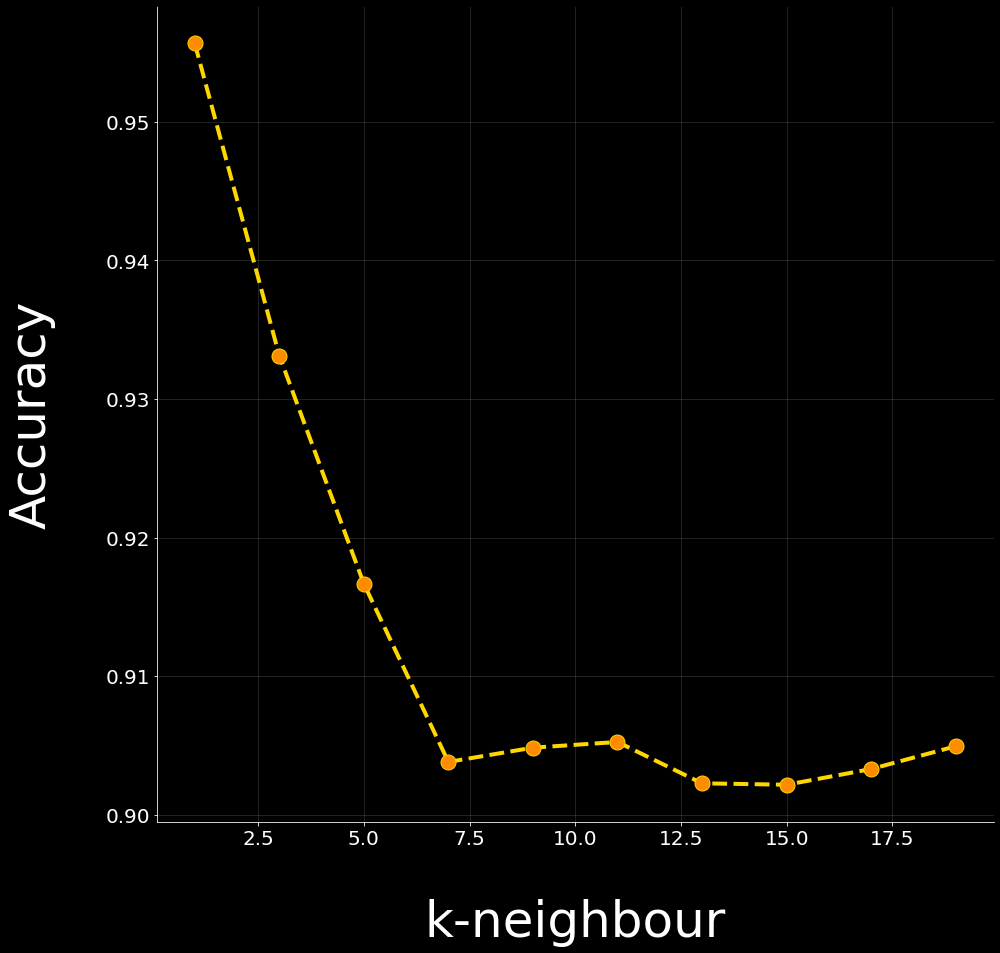

In [86]:
plot_line([el[0] for el in accuracies],[el[1] for el in accuracies], "k-neighbour", "Accuracy")

## Apply the model with the best parameters and plot ROC curve

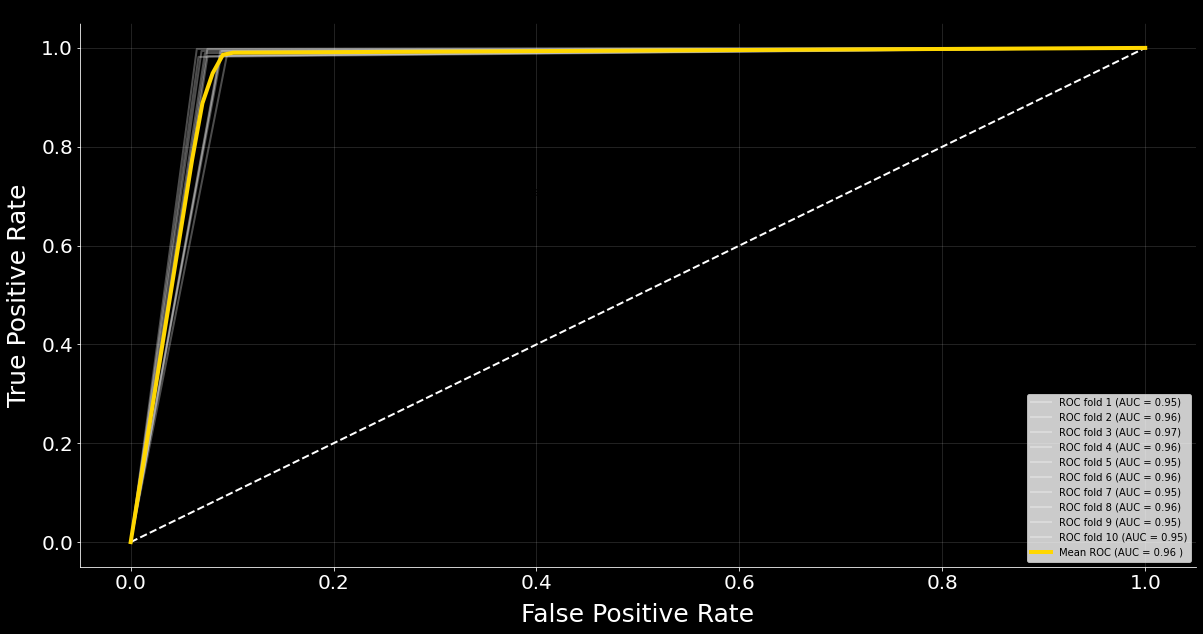

In [87]:
#Trovo le feature migliori

kfold = KFold(n_splits=10, random_state=123, shuffle=True)

model = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

sfs_kn = SFS(estimator = model, k_features=(3,17), cv=kfold, n_jobs=-1)

sfs_kn.fit(X_res, y_res)

temp_X_res = sfs_kn.transform(X_res)


#Calcolo la roc curve

kfold = KFold(n_splits=10, random_state=123, shuffle=True)

#model = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

fig, ax = plt.subplots(1,1,figsize=(20,10), facecolor="k")
plt.rcParams['axes.facecolor'] = 'k'
#out = cross_val_score(model, temp_X_res, y_res, scoring="roc_auc", cv=kfold, n_jobs=-1)

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train_index, test_index in kfold.split(temp_X_res, y_res):
    
    model = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

    X_train, X_test = temp_X_res[train_index], temp_X_res[test_index]
    y_train, y_test = y_res[train_index], y_res[test_index]
    
    model.fit(X_train, y_train)
    
    out = model.predict(X_test)
    
    fpr, tpr, t = roc_curve(y_test, out)
    
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    
    roc_auc = auc(fpr, tpr)
    
    aucs.append(roc_auc)
    
    ax.plot(fpr, tpr, lw=2, color="w", alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

ax.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'w')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
ax.plot(mean_fpr, mean_tpr, color='gold',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=4, alpha=1)

ax.set_xlabel('False Positive Rate',color="w", size=25, labelpad=10)
ax.set_ylabel('True Positive Rate', color="w", size=25, labelpad=10)
ax.set_title('ROC')
ax.legend(loc="lower right", facecolor="w")
ax.text(0.32,0.7,'More accurate area',fontsize = 12)
ax.text(0.63,0.4,'Less accurate area',fontsize = 12)


ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

plt.xticks(size = 20)
plt.yticks(size = 20)

ax.grid(color="lightgray", alpha = 0.2)


# Logistic Regression

## Find the best degree, c and features

In [97]:
accuracies = []

for degree in tqdm(range(1,4)):
    
    c_scores = []
    
    for c in [0.01,0.1,1,10,100]:
    
        kfold = KFold(n_splits=10, random_state=123, shuffle=True)

        model = LogisticRegression(solver="newton-cg", n_jobs=-1)

        sfs_kn = SFS(estimator = model, k_features=(3,17), cv=kfold, n_jobs=-1)

        sfs_kn.fit(X_res, y_res)

        temp_X_res = sfs_kn.transform(X_res)
        
        poly = PolynomialFeatures(degree = degree, interaction_only=False, include_bias=False)
        
        temp_X_res_poly = poly.fit_transform(temp_X_res)

        scores = cross_val_score(model, temp_X_res_poly, y_res, scoring='accuracy', cv=kfold, n_jobs=-1)

        c_scores.append((np.mean(scores), c, temp_X_res_poly.shape[1]))      
    
    
    accuracies.append([max(c_scores, key=lambda e: e[0])[0], max(c_scores, key=lambda e: e[0])[1], degree])

100%|████████████████████████████████████████████| 3/3 [07:04<00:00, 141.41s/it]


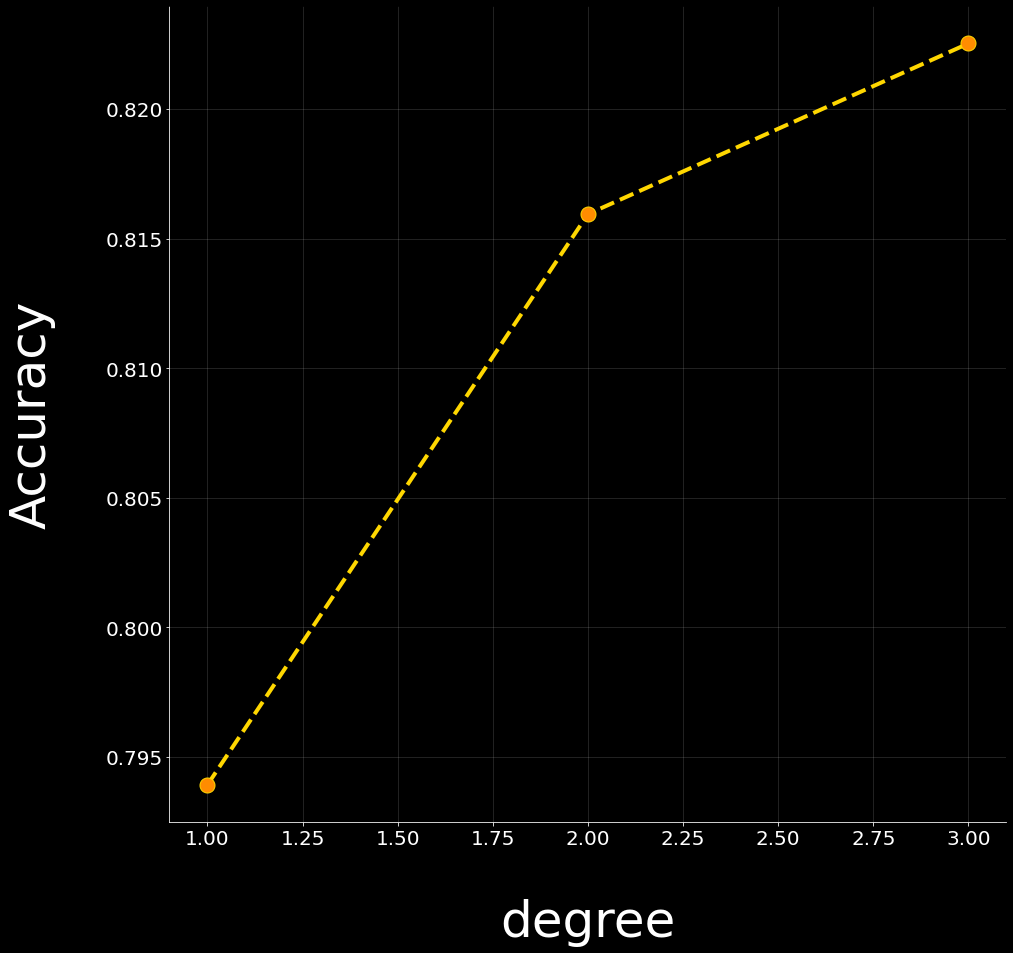

In [98]:
plot_line([el[2] for el in accuracies], [el[0] for el in accuracies], "degree", "Accuracy")

## Apply the model with the best parameters and plot ROC curve

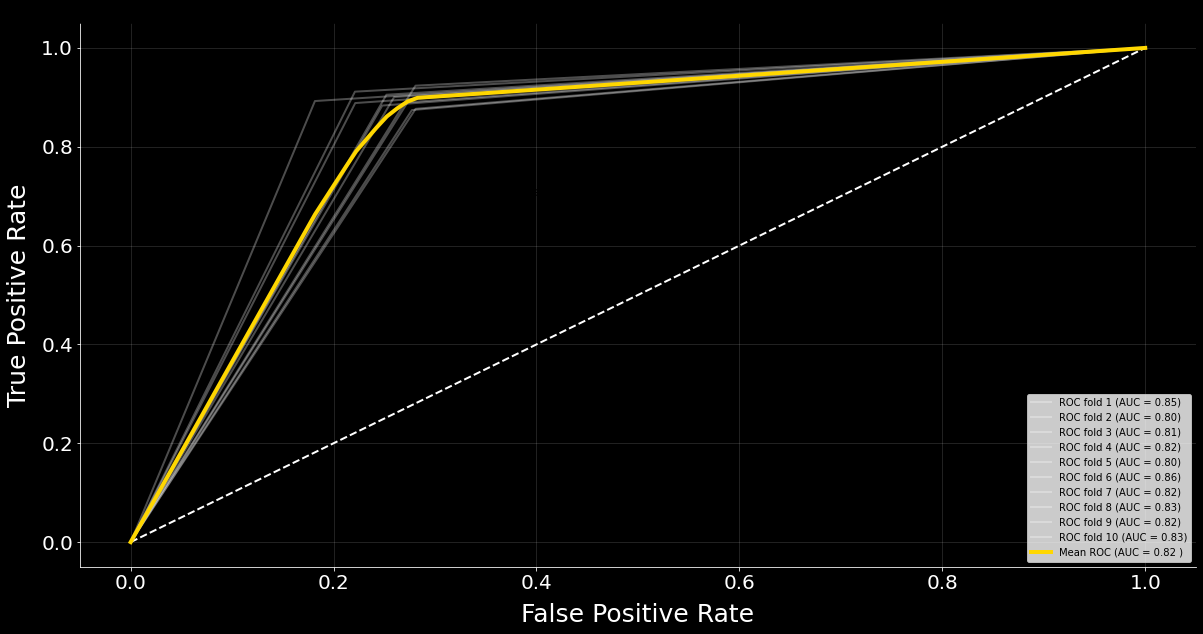

In [99]:
#Trovo le feature migliori

kfold = KFold(n_splits=10, random_state=123, shuffle=True)

model = LogisticRegression(solver="newton-cg", n_jobs=-1)

sfs_kn = SFS(estimator = model, k_features=(3,17), cv=kfold, n_jobs=-1)

sfs_kn.fit(X_res, y_res)

temp_X_res = sfs_kn.transform(X_res)

poly = PolynomialFeatures(degree = degree, interaction_only=False, include_bias=False)
        
temp_X_res_poly = poly.fit_transform(temp_X_res)


#Calcolo la roc curve

kfold = KFold(n_splits=10, random_state=123, shuffle=True)

#model = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

fig, ax = plt.subplots(1,1,figsize=(20,10), facecolor="k")
plt.rcParams['axes.facecolor'] = 'k'
#out = cross_val_score(model, temp_X_res, y_res, scoring="roc_auc", cv=kfold, n_jobs=-1)

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train_index, test_index in kfold.split(temp_X_res_poly, y_res):
    
    model = LogisticRegression(solver="newton-cg", n_jobs=-1)

    X_train, X_test = temp_X_res_poly[train_index], temp_X_res_poly[test_index]
    y_train, y_test = y_res[train_index], y_res[test_index]
    
    model.fit(X_train, y_train)
    
    out = model.predict(X_test)
    
    fpr, tpr, t = roc_curve(y_test, out)
    
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    
    roc_auc = auc(fpr, tpr)
    
    aucs.append(roc_auc)
    
    ax.plot(fpr, tpr, lw=2, color="w", alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

ax.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'w')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
ax.plot(mean_fpr, mean_tpr, color='gold',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=4, alpha=1)

ax.set_xlabel('False Positive Rate',color="w", size=25, labelpad=10)
ax.set_ylabel('True Positive Rate', color="w", size=25, labelpad=10)
ax.set_title('ROC')
ax.legend(loc="lower right", facecolor="w")
ax.text(0.32,0.7,'More accurate area',fontsize = 12)
ax.text(0.63,0.4,'Less accurate area',fontsize = 12)


ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

plt.xticks(size = 20)
plt.yticks(size = 20)

ax.grid(color="lightgray", alpha = 0.2)
